In [1]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from database import select_dataset
from graphmodels.utils import get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic
import pandas as pd
import numpy as np
from models.Hermen.model_BE2 import BE2_models


In [189]:
__author__ = 'Hermen'
__status__ = 'Pending Validation'

"""
TO DO.
"""
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import pandas as pd
import numpy as np

# To check naming, confusing with demand/prod + total not total
kg_to_1000tonnes = 1e-6
day_per_year = 365
ktonnes_to_hg = 1e7

FPi_nodes = {'FLOi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Food losses per food group'
                },
             'FDKGi': {
                'type': 'input',
                'unit': 'kg/capita/day',
                'name': 'Kg food demand per day per food group'
                },
             'SSRi': {
                'type': 'input',
                'unit': '1',
                'name': 'Self-sufficiency ratio per food group',
                },
             'FDPi': {
                'type': 'variable',
                'unit': '1000 tonnes',
                'name': 'Total food production per food group',
                'computation': lambda FDKGi, Pop, FLOi, **kwargs: kg_to_1000tonnes * day_per_year * FDKGi.fillna(0) * Pop * 1e3 + FLOi.fillna(0)
                },
             'OFi': {
                'type': 'variable',
                'unit': '1000 tonnes',
                'name': 'Other food demand',
                'computation': lambda SDi, NFDi, PDi, RDi, SVi, **kwargs: SDi.fillna(0) + NFDi.fillna(0) + PDi.fillna(0) + RDi.fillna(0) + SVi.fillna(0)
                },
             'SDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Seed demand per food group'
                },
             'NFDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Non-food demand per food group'
                },
             'PDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Processed demand per food group'
                },
             'RDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Residual demand per food group'
                },
             'SVi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Stock variation per food group'
                },
             'FPi': {
                'type': 'output',
                'name': 'Food production per food group',
                'unit': '1000 tonnes',
                'computation': lambda SSRi, OFi, FDi, FDPi, **kwargs: (OFi.fillna(0) + FDi.fillna(0) + FDPi.fillna(0)) * SSRi.fillna(1)
                },
             'FDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Feed demand per food group'
                },
             'Pop': {
                'type': 'input',
                'unit': '1000 persons',
                'name': 'Total population'
                }
        }

TCLDi_nodes = {'TCLDi': {
                  'type': 'output',
                  'name': 'Cropland demand',
                  'unit': 'ha',
                  'computation': lambda CYi, FPi, **kwargs: ktonnes_to_hg * FPi / CYi
                  },
               'CYi': {
                  'type': 'input',
                  'unit': 'hg/ha',
                  'name': 'Crop yields per crop type'
                  },
               'FPi': {
                  'type': 'input',
                  'name': 'Food production per food group',
                  'unit': '1000 tonnes'
                  },
               }

CL_nodes = {'TCLDi': {
               'type': 'input',
               'name': 'Cropland demand',
               'unit': 'ha',
               },
            'CL_corr_coef': {
               'type': 'input',
               'name': 'Correction coefficient',
               'unit': '1',
               },
            'CL_corr_intercept': {
               'type': 'input',
               'name': 'Correction intercept by country',
               'unit': '1000 ha',
               },
            'CL': {
               'type': 'output',
               'name': 'Cropland stock',
               'unit': '1000 ha',
               'computation':  lambda TCLDi, CL_corr_coef, **kwargs: TCLDi.groupby(level=['ISO', 'Year']).sum() * 1e-3 #*CL_corr_coef #+ CL_corr_intercept # Strange to check !
            },
}

IL_FL_nodes = {'CL': {
                  'type': 'input',
                  'name': 'Cropland stock',
                  'unit': '1000 ha',
                  },
               'CL_baseline': {
                  'type': 'input',
                  'name': 'Cropland stock baseline',
                  'unit': '1000 ha',
                  },
               'delta_CL': {
                  'type': 'variable',
                  'name': 'Change in cropland',
                  'unit': '1000 ha',
                  'computation': lambda CL, CL_baseline, **kwargs: CL - CL_baseline
                  },
               'IL_baseline': {
                  'type': 'input',
                  'unit': '1000 ha',
                  'name': 'Inactive land baseline'
                  },
               'FL_baseline': {
                  'type': 'input',
                  'unit': '1000 ha',
                  'name': 'Forest land baseline'
                  },
               'IL': {
                  'type': 'output',
                  'name': 'Inactive land stock',
                  'unit': '1000 ha',
                  'computation': lambda delta_CL, IL_baseline, **kwargs: (IL_baseline - delta_CL).clip(lower=0) # to double check
                  },
               'FL': {
                  'type': 'output',
                  'name': 'Forest land stock',
                  'unit': '1000 ha',
                  'computation': lambda delta_CL, FL_baseline, IL_baseline, **kwargs: FL_baseline + (IL_baseline - delta_CL).clip(upper=0) # to double check
                  }
               }

BE2_nodes = {'TLA':{
               'type': 'input',
               'unit': '1000 ha',
               'name': 'Total land area'
               },
             'FL': {
               'type': 'input',
               'unit': '1000 ha',
               'name': 'Forest land stock'
               },
             'IL': {
               'type': 'input',
               'unit': '1000 ha',
               'name': 'Inactive land stock'
               },
             'R_rate': {
               'type': 'parameter',
               'unit': '%',
               'name': 'Rate of reforestation'
               },
             'FL_RF': {
               'type': 'variable',
               'name': 'Forest land stock after reforestation policy',
               'unit': '1000 ha',
               'computation': lambda FL, R_rate, IL, **kwargs: FL + 1e-2 * R_rate * IL
               },
             'BE2': {
               'type': 'output',
               'name': 'Share of forest area to total land area',
               'unit': '%',
               'computation': lambda FL_RF, TLA, **kwargs: 1e2 * FL_RF / TLA
               }
             }


FPi_model = GraphModel(FPi_nodes)
TCLDi_partial_model = GraphModel(TCLDi_nodes)
TCLDi_model = GraphModel(concatenate_graph_specs([TCLDi_nodes, FPi_nodes]))
IL_FL_model = GraphModel(IL_FL_nodes)
BE2_partial_model = GraphModel(BE2_nodes)
BE2_model = GraphModel(concatenate_graph_specs([BE2_nodes, IL_FL_nodes, CL_nodes, TCLDi_nodes, FPi_nodes]))

BE2_models = {
        'TCLDi_model': TCLDi_model,
        'TCLDi_partial_model': TCLDi_model,
        'FPi_model': FPi_model,
        'IL_FL_model': IL_FL_model,
        'BE2_partial_model': BE2_partial_model,
        'BE2_model': BE2_model
         }



model_df = pd.read_csv('outputs/BE2_df.csv')
landuse = pd.read_csv('outputs/landuse.csv')
corrected_cl = pd.read_csv('outputs/cl_corr.csv')

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_(
    ) + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)

    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))

    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
]

data_dict = df_to_data_dict(model_df, itemized)


data_dict.update(df_to_data_dict(landuse, itemized=[]))

data_dict['CL_baseline'] = data_dict['CL']
data_dict['IL_baseline'] = data_dict['IL']
data_dict['FL_baseline'] = data_dict['FL']
data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)


#data_dict['CL_corr_intercept'] = corrected_cl.query('name != "comp"').rename(columns={"name": 'ISO'}).set_index('ISO')['coef']
#data_dict['CL_corr_coef'] = pd.Series(data=corrected_cl.query('name == "comp"')['coef'].values[0], index=data_dict['CL_corr_intercept'].index)
data_dict['CL_corr_coef'] = pd.read_csv('outputs/cl_corr.csv', index_col='ISO')['CL_corr']

def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values(
        'ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index)


def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(
        2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_percent_target_projection(series, percent_target=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values
    return series.interpolate()


def apply_itemized_percent_target_projection(series, percent_target=0):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = expand_series_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values

    return series.groupby(level=['ISO', 'Item']).apply(lambda group: group.interpolate())


def apply_annual_rate_projection(series, rate=1):
    series = series.copy()
    series = expand_series_non_itemized(series)

    year = series.loc[:, 2019:].index.get_level_values(level='Year').values

    series.loc[:, 2019:] = series.loc[:, 2018].values * rate ** (year - 2019)

    return series


def apply_constant_projection(series, constant=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2018:] = constant

    return series


def apply_itemized_ffill_projection(series):
    series = series.copy()
    series = expand_series_itemized(series)

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')


def apply_ffill_projection(series):
    series = series.copy()
    series = expand_series_non_itemized(series)

    return series.groupby(['ISO']).fillna(method='ffill')


def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)

    return results


def run_BE2_projection(data_dict):
    data_dict = data_dict.copy()
    
    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x),
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
     }
     
    
    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict


/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [223]:
ISO = 'FRA'
filtered_data_dict = {k: v.loc[ISO, 2000:] for k, v in data_dict.items() if k not in ['CL_corr_intercept', 'CL_corr_coef']}

filtered_data_dict['CL_corr_coef'] = data_dict['CL_corr_coef'].loc[ISO]

filtered_data_dict = run_BE2_projection(filtered_data_dict)

res = run_BE2_scenario(data_dict=filtered_data_dict, FDKGi_target=0.75, FLOi_target=1, CYi_target=1, R_rate=0)

res['BE2'].loc[:, 2014:]

ISO  Year
FRA  2014    30.595171
     2015    30.747484
     2016    30.899797
     2017    31.052110
     2018    31.204423
     2019    31.204423
     2020    31.204423
     2021    31.204423
     2022    31.204423
     2023    31.204423
     2024    31.204423
     2025    31.204423
     2026    31.204423
     2027    31.204423
     2028    31.204423
     2029    31.204423
     2030    31.204423
     2031    31.204423
     2032    31.204423
     2033    31.204423
     2034    31.204423
     2035    31.204423
     2036    31.204423
     2037    31.204423
     2038    31.204423
     2039    31.204423
     2040    31.204423
     2041    31.204423
     2042    31.204423
     2043    31.204423
     2044    31.204423
     2045    31.204423
     2046    31.204423
     2047    31.204423
     2048    31.204423
     2049    31.204423
     2050    31.204423
dtype: float64

In [224]:
(res['FPi'] / res['CYi']).loc[:, 2016,:].replace(0, np.nan).replace(np.inf, np.nan).dropna()

ISO  Item          
FRA  Oats              0.008542
     Oilcrops          0.230506
     Sugar beet        0.040499
     Sunflower seed    0.053678
     Sugar cane        0.003806
dtype: float64

In [225]:
res['FPi'].loc[:, 2014, :].replace(0, np.nan).dropna()

ISO  Item              
FRA  Oats                    443.366627
     Oilcrops               7488.002171
     Sugar beet            37845.000000
     Sunflower seed         1584.000000
     Alcohol, Non-Food       773.502890
                               ...     
     Vegetables             5332.600721
     Vegetables, Other      4346.047767
     Wheat and products    38949.324940
     Wine                   4741.976758
     Yams                      3.965280
Length: 101, dtype: float64

In [215]:
res['FPi'].loc[:, 2014].replace(0, np.nan).dropna()

ISO  Item              
HUN  Oats                   136.593212
     Oilcrops              2438.809277
     Sugar beet            1065.597898
     Sunflower seed        1595.860913
     Alcohol, Non-Food      257.000000
                              ...     
     Vegetable Oils         625.411395
     Vegetables            1546.588724
     Vegetables, Other     1332.113501
     Wheat and products    5261.408269
     Wine                   258.941918
Length: 90, dtype: float64

In [221]:
res['CYi'].loc[:, 2014, :].replace(0, np.nan).dropna()

ISO  Item                              
HUN  Almonds, with shell                     7778.000000
     Anise, badian, fennel, coriander       14231.000000
     Apples                                234471.000000
     Apricots                               50525.000000
     Asparagus                              51260.000000
                                               ...      
     Eggplants (aubergines)                322500.000000
     Groundnuts, with shell                 11111.333333
     Leeks, other alliaceous vegetables    140000.000000
     Vetches                                 7500.000000
     Cow peas, dry                          11250.000000
Name: CYi, Length: 89, dtype: float64

In [194]:
pd.concat([res['CYi'], res['FPi']], axis=1).replace(0, np.nan).dropna().loc[:, 2014, :]

CYi            0
ISO Item                                 
HUN Oats             26660.0   136.593212
    Oilcrops         27665.0  2438.809277
    Sugar beet      691796.0  1065.597898
    Sunflower seed   26902.0  1595.860913

In [195]:
res['FPi'].loc[:, :, ]

ISO  Year  Item                            
HUN  2000  Almonds, with shell                 0.0
           Anise, badian, fennel, coriander    0.0
           Apples                              0.0
           Apricots                            0.0
           Asparagus                           0.0
                                              ... 
     2050  Yams                                0.0
           Berries nes                         0.0
           Blueberries                         0.0
           Fruit, pome nes                     0.0
           Artichokes                          0.0
Length: 10251, dtype: float64

In [182]:
pd.concat([res['CYi'], res['FPi']], axis=1).loc[:, 2014, :].dropna()

CYi    0
ISO Item                                                  
HUN Almonds, with shell                   7778.000000  0.0
    Anise, badian, fennel, coriander     14231.000000  0.0
    Apples                              234471.000000  0.0
    Apricots                             50525.000000  0.0
    Asparagus                            51260.000000  0.0
...                                               ...  ...
    Eggplants (aubergines)              322500.000000  0.0
    Groundnuts, with shell               11111.333333  0.0
    Leeks, other alliaceous vegetables  140000.000000  0.0
    Vetches                               7500.000000  0.0
    Cow peas, dry                        11250.000000  0.0

[89 rows x 2 columns]

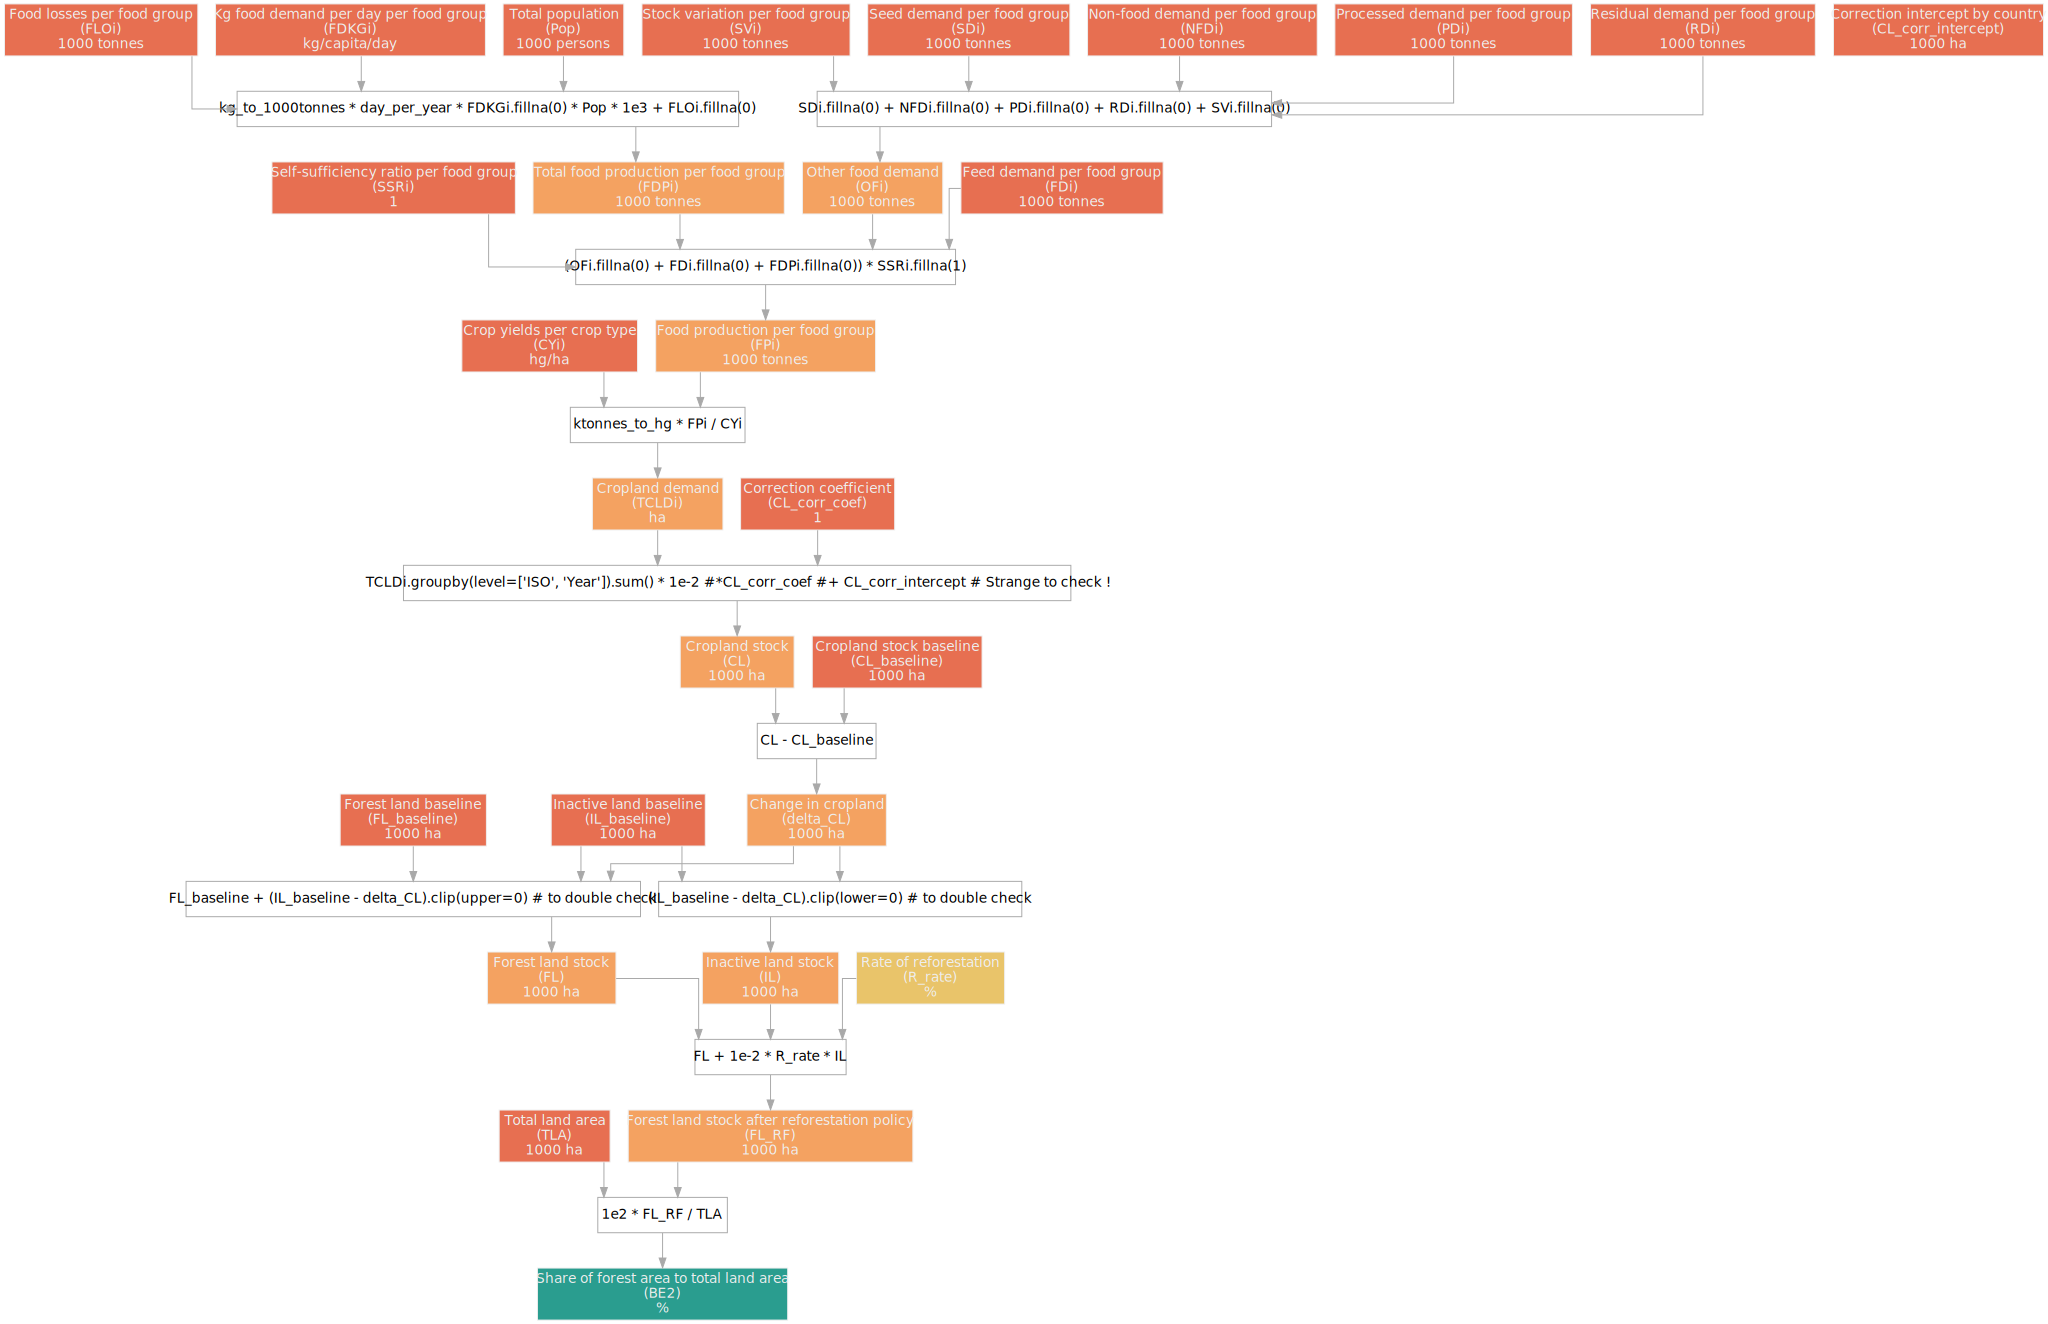

In [183]:
BE2_model.draw()